In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import math
!pip install pmdarima
import seaborn as sns
from matplotlib.dates import DateFormatter
from scipy.stats import mode

In [3]:
df = pd.read_csv("data/fussgängerzahlen.csv")
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%dT%XZ")

df = df[["timestamp", "location_id", "weather_condition", "temperature", "adult_pedestrians_count", "child_pedestrians_count"]]
df["pedestrians_count"] = (df.adult_pedestrians_count + df.child_pedestrians_count).round(0).astype(int)
df.drop(columns=["adult_pedestrians_count","child_pedestrians_count"], inplace=True)

df_new = df.pivot(index="timestamp", columns=["location_id"], values="pedestrians_count").reset_index().rename_axis(None, axis=1)
df_new = df_new.rename(columns={"timestamp": "datetime", 329: "bhfs_south", 330: "bhfs_middle", 331: "bhfs_north"})
df_new.replace(0, np.nan, inplace=True) # replace 0's with NaNs

## Visualization of Target Variable

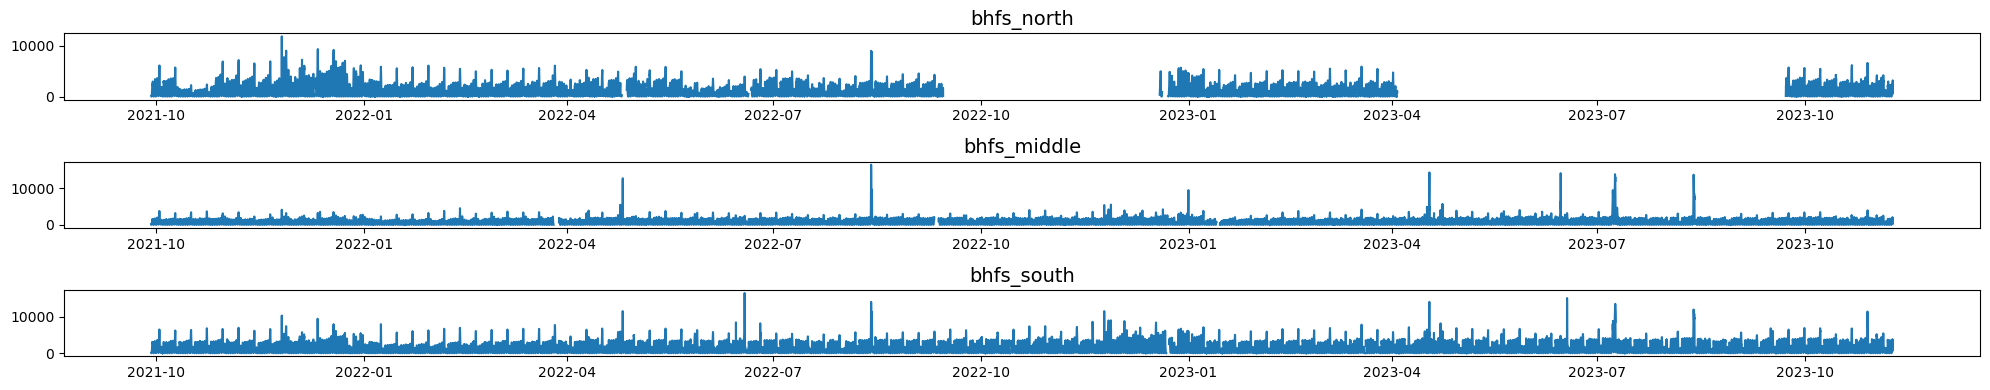

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(20, 4))
axs[0].plot(df_new.datetime, df_new.bhfs_north)
axs[0].set_title("bhfs_north", fontsize=14)
axs[1].plot(df_new.datetime, df_new.bhfs_middle)
axs[1].set_title("bhfs_middle", fontsize=14)
axs[2].plot(df_new.datetime, df_new.bhfs_south)
axs[2].set_title("bhfs_south", fontsize=14)
plt.tight_layout();

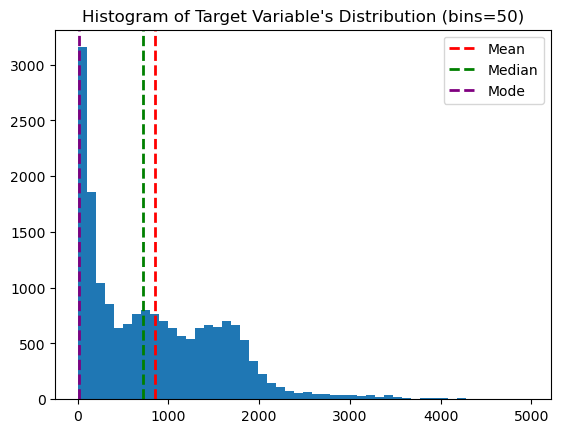

In [4]:
df_hist = df_new.loc[df_new.bhfs_middle < 5000]

fig, ax = plt.subplots()

ax.hist(df_hist.bhfs_middle, bins=50)
ax.set_title("Histogram of Target Variable's Distribution (bins=50)")

ax.axvline(df_hist.bhfs_middle.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
ax.axvline(df_hist.bhfs_middle.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
ax.axvline(mode(df_hist.bhfs_middle).mode, color='purple', linestyle='dashed', linewidth=2, label='Mode')
ax.legend();

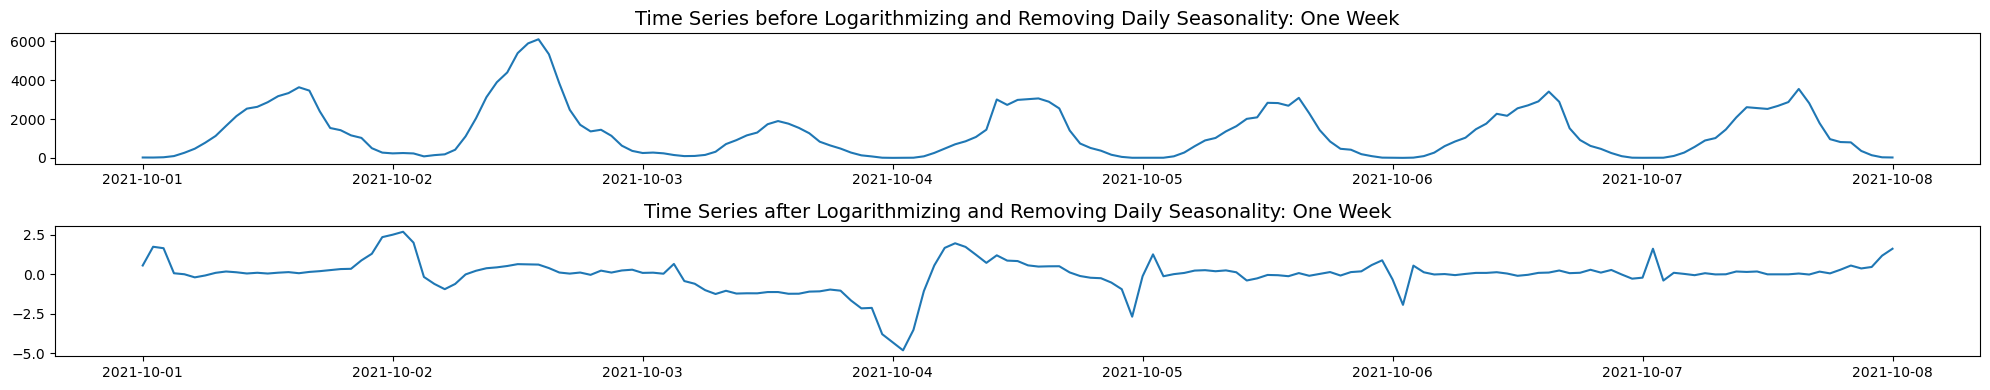

In [5]:
start_date3 = '2021-10-01 00:00:00'
end_date3 = '2021-10-08 00:00:00'

mask3 = (df_new['datetime'] >= start_date3) & (df_new['datetime'] <= end_date3)

df_new1 = df_new.dropna().copy()
df_log_diff = pd.DataFrame(((np.log(df_new1["bhfs_north"])).diff(24)))
df_log_diff["datetime"] = df_new1["datetime"]

fig, axs = plt.subplots(2, 1, figsize=(20, 4))
axs[0].plot(df_new.loc[mask3, "datetime"], df_new.loc[mask3, "bhfs_north"])
axs[0].set_title("Time Series before Logarithmizing and Removing Daily Seasonality: One Week", fontsize=14)
axs[1].plot(df_log_diff.loc[mask3, "datetime"], df_log_diff.loc[mask3, "bhfs_north"])
axs[1].set_title("Time Series after Logarithmizing and Removing Daily Seasonality: One Week", fontsize=14)
plt.tight_layout();

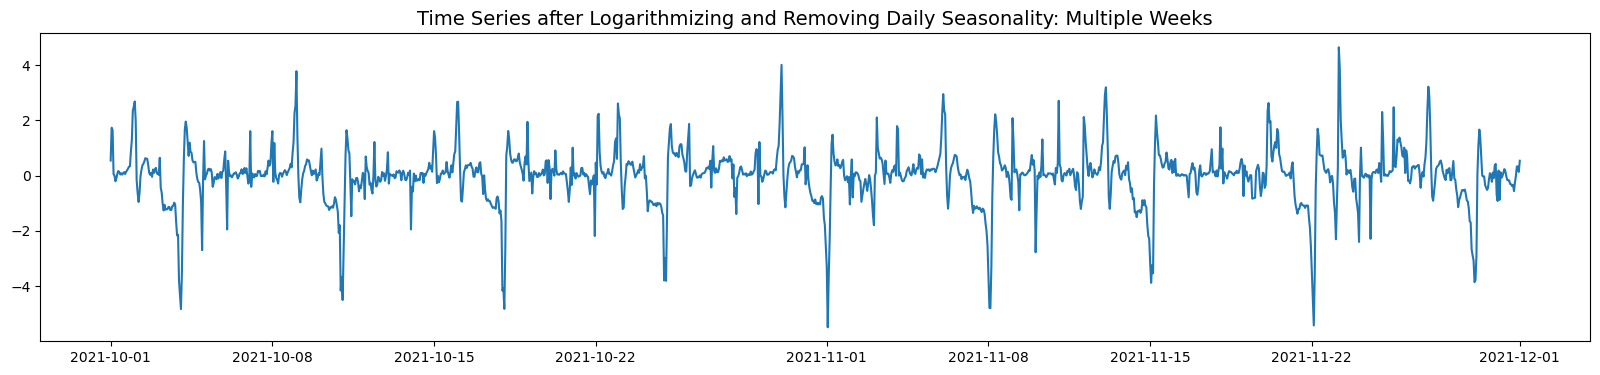

In [6]:
start_date4 = '2021-10-01 00:00:00'
end_date4 = '2021-12-01 00:00:00'

mask4 = (df_new['datetime'] >= start_date4) & (df_new['datetime'] <= end_date4)

df_new1 = df_new.dropna().copy()
df_log_diff = pd.DataFrame(((np.log(df_new1["bhfs_north"])).diff(24)))
df_log_diff["datetime"] = df_new1["datetime"]

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(df_log_diff.loc[mask4, "datetime"], df_log_diff.loc[mask4, "bhfs_north"])
ax.set_title("Time Series after Logarithmizing and Removing Daily Seasonality: Multiple Weeks", fontsize=14);

## Imputation of the two major gaps in bhfs_norths with different models

In [4]:
# boring stuff that has to be done in the beginning

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

start_date1 = '2022-09-14 11:00:00'
end_date1 = '2022-12-22 23:00:00'
start_date2 = '2023-04-03 10:00:00'
end_date2 = '2023-09-22 07:00:00'

# mse preparation
df_mse = df_new[["datetime", "bhfs_south", "bhfs_middle", "bhfs_north"]].copy()
df_mse.drop(df_mse[(df_mse['datetime'] >= start_date1) & (df_mse['datetime'] <= end_date1)].index, inplace=True)
df_mse.drop(df_mse[(df_mse['datetime'] >= start_date2) & (df_mse['datetime'] <= end_date2)].index, inplace=True)

# in order to use IterativeImputer, the data has to be standardized
scaler = StandardScaler()

# Fit the scaler on the data and transform the DataFrame
scaled_data = scaler.fit_transform(df_mse[["bhfs_south", "bhfs_middle", "bhfs_north"]])

# Create a new DataFrame with the scaled data
df_mse_scaled = pd.DataFrame(scaled_data, columns=(["bhfs_south", "bhfs_middle", "bhfs_north"]))

# Initialize IterativeImputer with custom imputation strategy
imputer = IterativeImputer(max_iter=15, random_state=0, imputation_order='ascending')

# Transform the data to fill missing values
df_imputed_values = imputer.fit_transform(df_mse_scaled[["bhfs_south", "bhfs_middle", "bhfs_north"]])

# Create a DataFrame with imputed values
df_imp = pd.DataFrame(df_imputed_values, columns=["bhfs_south", "bhfs_middle", "bhfs_north"]).reset_index(drop=True)

# Reverse the scaling operation
original_data = scaler.inverse_transform(df_imp)

# Create a new DataFrame with the original data
df_original = pd.DataFrame(original_data, columns=df_imp.columns)

df_mse.drop(columns=["bhfs_south", "bhfs_middle", "bhfs_north"], inplace=True)
df_mse = df_mse.reset_index(drop=True)

df_ = pd.merge(df_mse, df_original, left_index=True, right_index=True, how="left")

df_train = df_.loc[df_.index <= 7991]
df_test = df_.loc[df_.index > 7991]
df_test = df_test.reset_index(drop=True)

## Mean Imputation

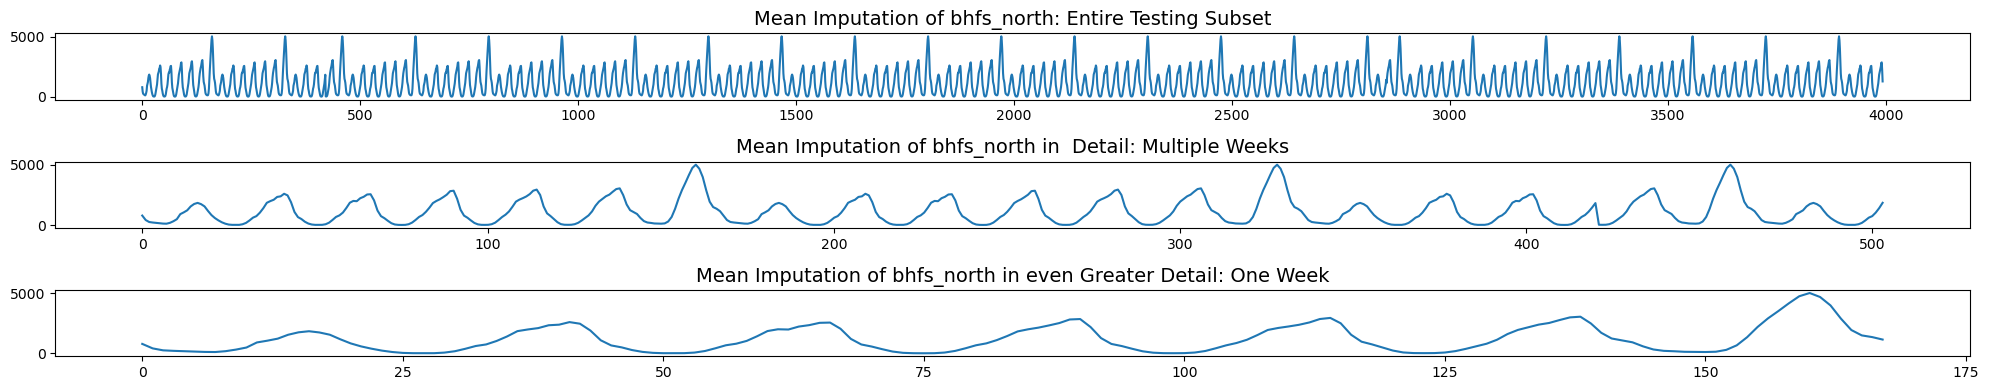

In [5]:
# imputation with mean from each hour of each weekday
def mean_imputation(df):
    for column in ("bhfs_north", "bhfs_middle", "bhfs_south"):
        
        # Step 1: Calculate mean values for non-NaN entries
        non_zero_means = df[df[column].notna()].groupby([df['datetime'].dt.weekday, df['datetime'].dt.time])[column].mean()

        # Step 2: Replace NaN values with the calculated means
        df[column] = df.apply(lambda row: non_zero_means.get((row['datetime'].weekday(), row['datetime'].time()), row[column]) 
                                          if math.isnan(row[column]) else row[column], axis=1)
    return df

df_test["y_hat_mean"] = np.nan

# apply the logic to df_test
non_zero_means = df_train[df_train["bhfs_north"].notna()].groupby([df_train['datetime'].dt.weekday, df_train['datetime'].dt.time])["bhfs_north"].mean()
df_test["y_hat_mean"] = df_test.apply(lambda row: non_zero_means.get((row['datetime'].weekday(), row['datetime'].time()), row["y_hat_mean"]) 
                            if math.isnan(row["y_hat_mean"]) else row["y_hat_mean"], axis=1)

mse_mean_imputation = mse(df_test.bhfs_north, df_test.y_hat_mean)

fig, axs = plt.subplots(3, 1, figsize=(20, 4))
axs[0].plot(df_test.y_hat_mean)
axs[0].set_title("Mean Imputation of bhfs_north: Entire Testing Subset", fontsize=14)
axs[1].plot(df_test[:504].y_hat_mean)
axs[1].set_title("Mean Imputation of bhfs_north in  Detail: Multiple Weeks", fontsize=14)
axs[2].plot(df_test[:168].y_hat_mean)
axs[2].set_title("Mean Imputation of bhfs_north in even Greater Detail: One Week", fontsize=14)
plt.tight_layout();

## Factor Imputation

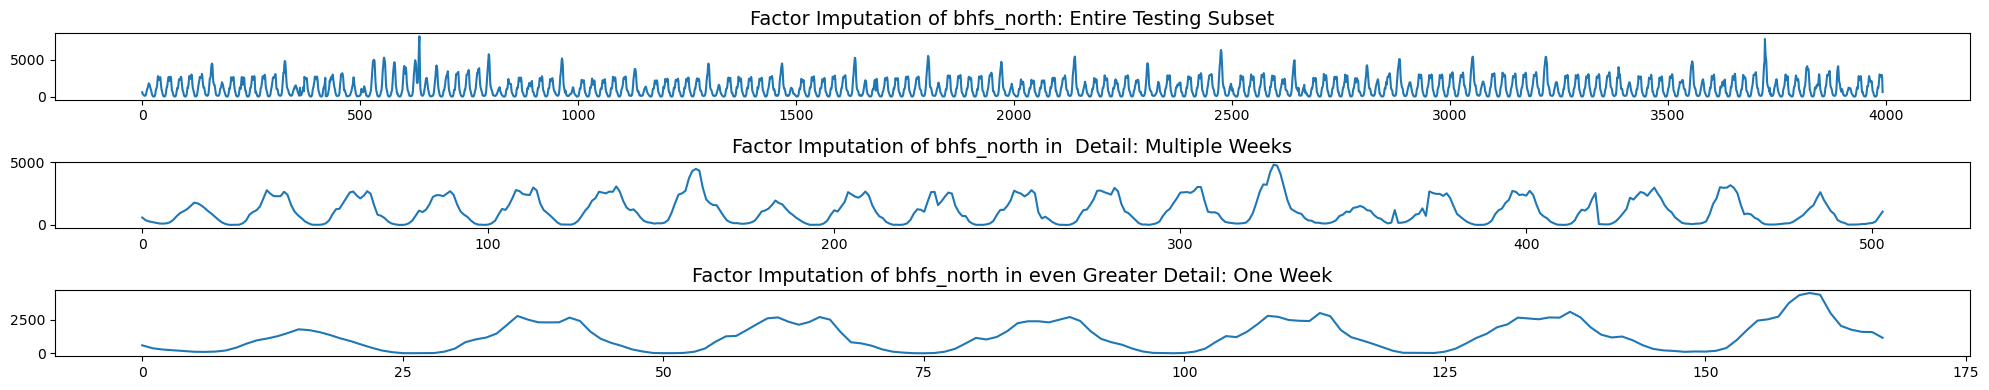

In [6]:
df_test["y_hat_f1"] = np.nan

factor1 = (df_train.bhfs_north.mean())/(df_train.bhfs_middle.mean() + df_train.bhfs_south.mean())
df_test["y_hat_f1"].fillna((df_test["bhfs_middle"] + df_test["bhfs_south"]) * factor1, inplace=True)

mse_f1_imputation = mse(df_test.bhfs_north, df_test.y_hat_f1)

fig, axs = plt.subplots(3, 1, figsize=(20, 4))
axs[0].plot(df_test.y_hat_f1)
axs[0].set_title("Factor Imputation of bhfs_north: Entire Testing Subset", fontsize=14)
axs[1].plot(df_test[:504].y_hat_f1)
axs[1].set_title("Factor Imputation of bhfs_north in  Detail: Multiple Weeks", fontsize=14)
axs[2].plot(df_test[:168].y_hat_f1)
axs[2].set_title("Factor Imputation of bhfs_north in even Greater Detail: One Week", fontsize=14)
plt.tight_layout();

## Multiple Factor Imputation

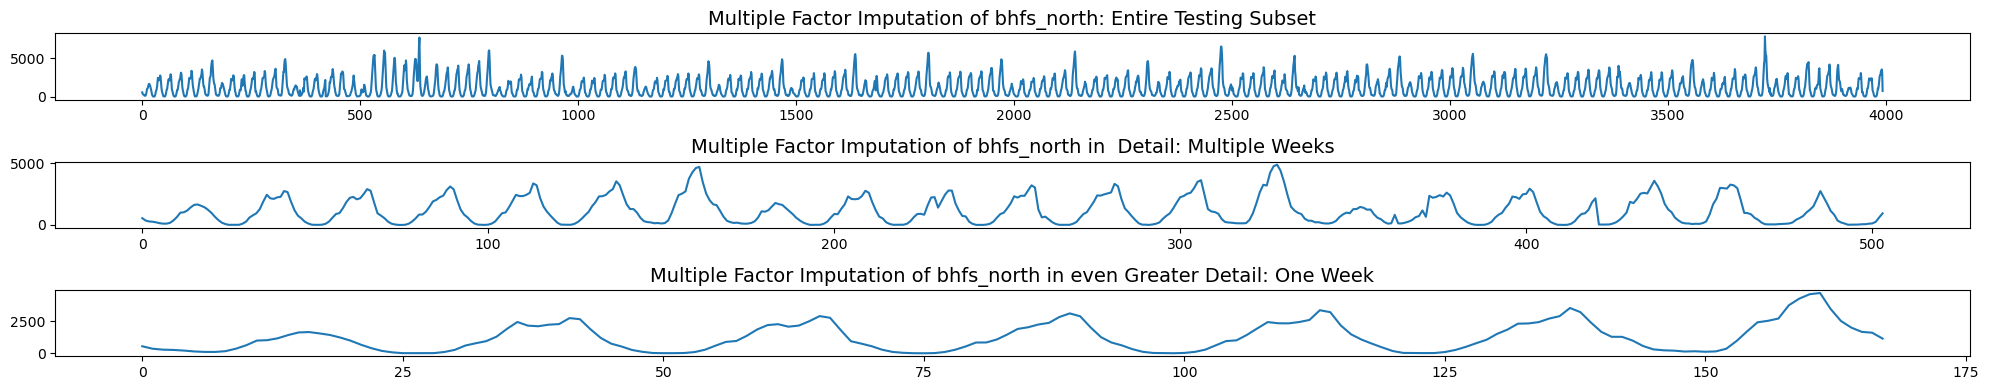

In [7]:
def multiple_factor_imputation(df):
    df_values = df.dropna()
    
    # Step 1: Calculate factors between bhfs_north and (bhfs_middle + bhfs_south)
    factors = df_values.groupby([df_values['datetime'].dt.weekday, df_values['datetime'].dt.time])["bhfs_north"].mean() / (
        df_values.groupby([df_values['datetime'].dt.weekday, df_values['datetime'].dt.time])["bhfs_middle"].mean() +
        df_values.groupby([df_values['datetime'].dt.weekday, df_values['datetime'].dt.time])["bhfs_south"].mean()
    )

    # Step 2: Replace NaN values of bhfs_north by multiplying (bhfs_middle + bhfs_south) with the factors
    df["bhfs_north"] = df.apply(lambda row: factors[(row['datetime'].weekday(), row['datetime'].time())] *
                                (row["bhfs_middle"] + row["bhfs_south"])
                                if math.isnan(row["bhfs_north"]) else row["bhfs_north"], axis=1)

    return df

df_test["y_hat_f2"] = np.nan

# Step 1: Calculate factors between bhfs_north and (bhfs_middle + bhfs_south)
factors2 = df_train.groupby([df_train['datetime'].dt.weekday, df_train['datetime'].dt.time])["bhfs_north"].mean() / (
df_train.groupby([df_train['datetime'].dt.weekday, df_train['datetime'].dt.time])["bhfs_middle"].mean() +
df_train.groupby([df_train['datetime'].dt.weekday, df_train['datetime'].dt.time])["bhfs_south"].mean()
)

# Step 2: Replace NaN values of bhfs_north by multiplying (bhfs_middle + bhfs_south) with the factors
df_test["y_hat_f2"] = df_test.apply(lambda row: factors2[(row['datetime'].weekday(), row['datetime'].time())] *
                            (row["bhfs_middle"] + row["bhfs_south"])
                            if math.isnan(row["y_hat_f2"]) else row["y_hat_f2"], axis=1)

mse_f2_imputation = mse(df_test.bhfs_north, df_test.y_hat_f2)

fig, axs = plt.subplots(3, 1, figsize=(20, 4))
axs[0].plot(df_test.y_hat_f2)
axs[0].set_title("Multiple Factor Imputation of bhfs_north: Entire Testing Subset", fontsize=14)
axs[1].plot(df_test[:504].y_hat_f2)
axs[1].set_title("Multiple Factor Imputation of bhfs_north in  Detail: Multiple Weeks", fontsize=14)
axs[2].plot(df_test[:168].y_hat_f2)
axs[2].set_title("Multiple Factor Imputation of bhfs_north in even Greater Detail: One Week", fontsize=14)
plt.tight_layout();

## Iterative Imputation

In [12]:
# without logarithmizing
df_test["y_hat_ii"] = np.nan

df_train_ii = df_train[["bhfs_south", "bhfs_middle", "bhfs_north"]].copy()
df_test_ii = df_test[["bhfs_south", "bhfs_middle", "y_hat_ii"]].copy()

# Initialize IterativeImputer with custom imputation strategy
imputer = IterativeImputer(max_iter=15, random_state=0, imputation_order='ascending')

# create new column to have same terminology between df_train and df_test
df_train_ii["y_hat_ii"] = df_train_ii["bhfs_north"]

imputer.fit(df_train_ii[["bhfs_south", "bhfs_middle", "y_hat_ii"]])

imputed_values = imputer.transform(df_test_ii[["bhfs_south", "bhfs_middle", "y_hat_ii"]])

# Create a DataFrame with imputed values
df_test_ii_imputed = pd.DataFrame(imputed_values, columns=["bhfs_south", "bhfs_middle", "y_hat_ii"])

mse_iterative_imputation = mse(df_test.bhfs_north, df_test_ii_imputed.y_hat_ii)
print(mse_iterative_imputation.round(0).astype(int))

79112


64177


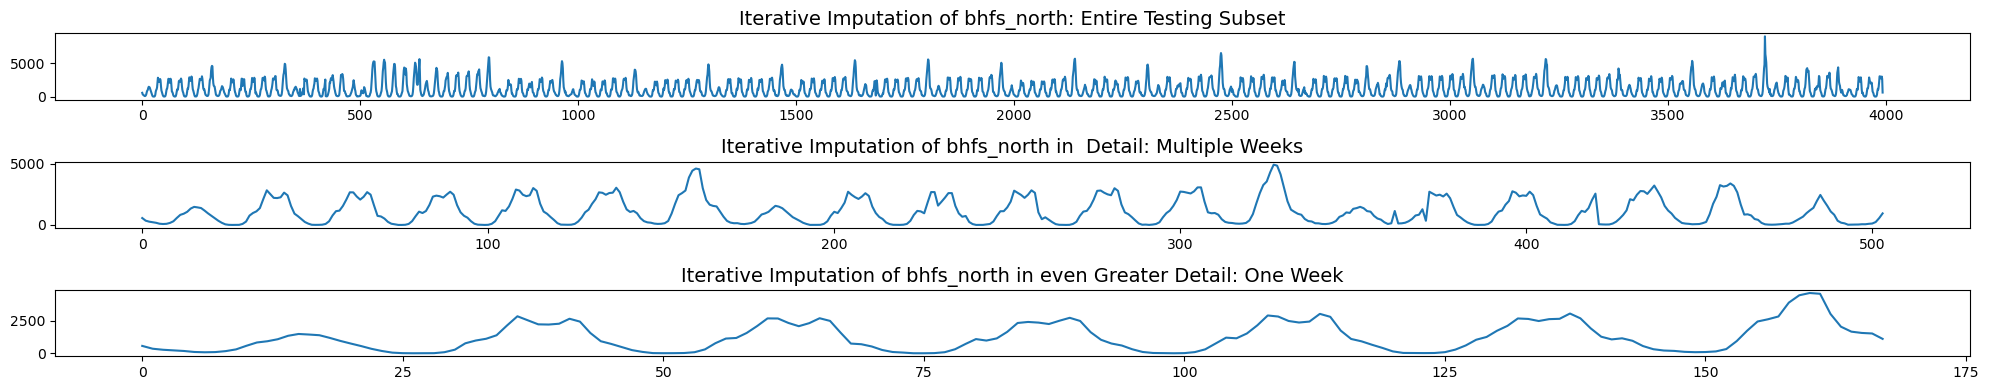

In [13]:
# with logarithmizing
df_test["y_hat_ii"] = np.nan

df_train_ii = df_train[["bhfs_south", "bhfs_middle", "bhfs_north"]].copy()
df_test_ii = df_test[["bhfs_south", "bhfs_middle", "y_hat_ii"]].copy()

df_train_ii_log = np.log(df_train_ii)
df_test_ii_log = np.log(df_test_ii)

# Initialize IterativeImputer with custom imputation strategy
imputer = IterativeImputer(max_iter=15, random_state=0, imputation_order='ascending')

# create new column to have same terminology between df_train and df_test
df_train_ii_log["y_hat_ii"] = df_train_ii_log["bhfs_north"]

imputer.fit(df_train_ii_log[["bhfs_south", "bhfs_middle", "y_hat_ii"]])

imputed_values = imputer.transform(df_test_ii_log[["bhfs_south", "bhfs_middle", "y_hat_ii"]])

# Create a DataFrame with imputed values
df_test_ii_log_imputed = pd.DataFrame(imputed_values, columns=["bhfs_south", "bhfs_middle", "y_hat_ii"])

df_original = np.exp(df_test_ii_log_imputed)

mse_iterative_imputation = mse(df_test.bhfs_north, df_original.y_hat_ii)
print(mse_iterative_imputation.round(0).astype(int))

fig, axs = plt.subplots(3, 1, figsize=(20, 4))
axs[0].plot(df_original.y_hat_ii)
axs[0].set_title("Iterative Imputation of bhfs_north: Entire Testing Subset", fontsize=14)
axs[1].plot(df_original.y_hat_ii[:504])
axs[1].set_title("Iterative Imputation of bhfs_north in  Detail: Multiple Weeks", fontsize=14)
axs[2].plot(df_original.y_hat_ii[:168])
axs[2].set_title("Iterative Imputation of bhfs_north in even Greater Detail: One Week", fontsize=14)
plt.tight_layout();

In [16]:
# Linear Regression & Random Forests
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df_test["y_hat_lr"] = np.nan
df_test["y_hat_rf"] = np.nan

linmod = LinearRegression(fit_intercept=True)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

df_train_m = np.log(df_train[["bhfs_south", "bhfs_middle", "bhfs_north"]].copy())
df_test_m = np.log(df_test[["bhfs_south", "bhfs_middle", "bhfs_north", "y_hat_lr", "y_hat_rf"]].copy())

linmod.fit(df_train_m[["bhfs_south", "bhfs_middle"]], df_train_m["bhfs_north"])

df_test_m["y_hat_lr"] = linmod.predict(df_test_m[["bhfs_south", "bhfs_middle"]])

rf_model.fit(df_train_m[["bhfs_south", "bhfs_middle"]], df_train_m["bhfs_north"])

df_test_m["y_hat_rf"] = rf_model.predict(df_test_m[["bhfs_south", "bhfs_middle"]])

df_test_m = np.exp(df_test_m[["bhfs_north", "y_hat_lr", "y_hat_rf"]])

mse_lr_imputation = mse(df_test_m["bhfs_north"], df_test_m["y_hat_lr"])
mse_rf_imputation = mse(df_test_m["bhfs_north"], df_test_m["y_hat_rf"])

## Comparisons

In [19]:
((mse_f1_imputation-mse_f2_imputation)/mse_f1_imputation)
((mse_lr_imputation-mse_f2_imputation)/mse_lr_imputation)

0.23983791407340446

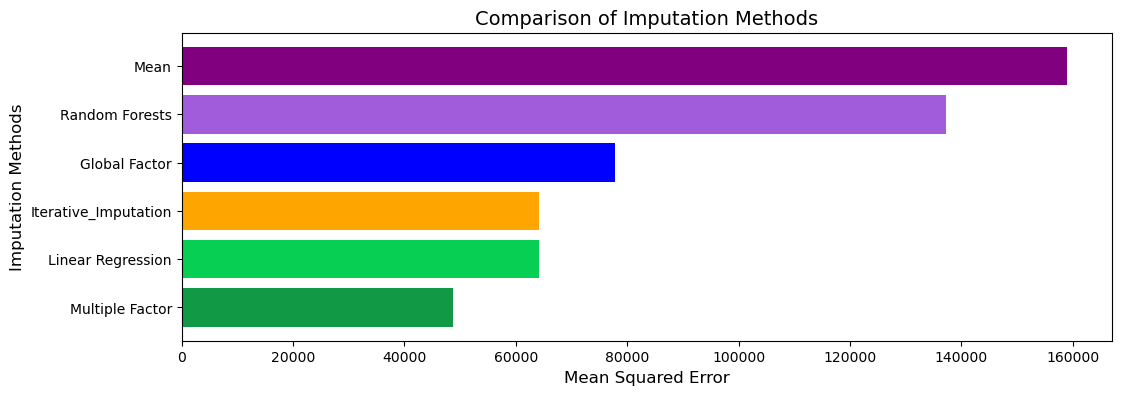

In [17]:
values = [mse_f2_imputation, mse_lr_imputation, mse_iterative_imputation, mse_f1_imputation, mse_rf_imputation, mse_mean_imputation]
methods = ['Multiple Factor', "Linear Regression", "Iterative_Imputation", 'Global Factor', "Random Forests",'Mean']

colors = ['#119945', "#06cf53", 'orange', 'blue', "#a05cdb", "purple"]

# Create a bar plot without error bars
fig, ax = plt.subplots(figsize=(12, 4))
ax.barh(methods, values, color=colors)
ax.set_title('Comparison of Imputation Methods', fontsize=14)
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Imputation Methods', fontsize=12)
ax.tick_params(axis='x', rotation=0)

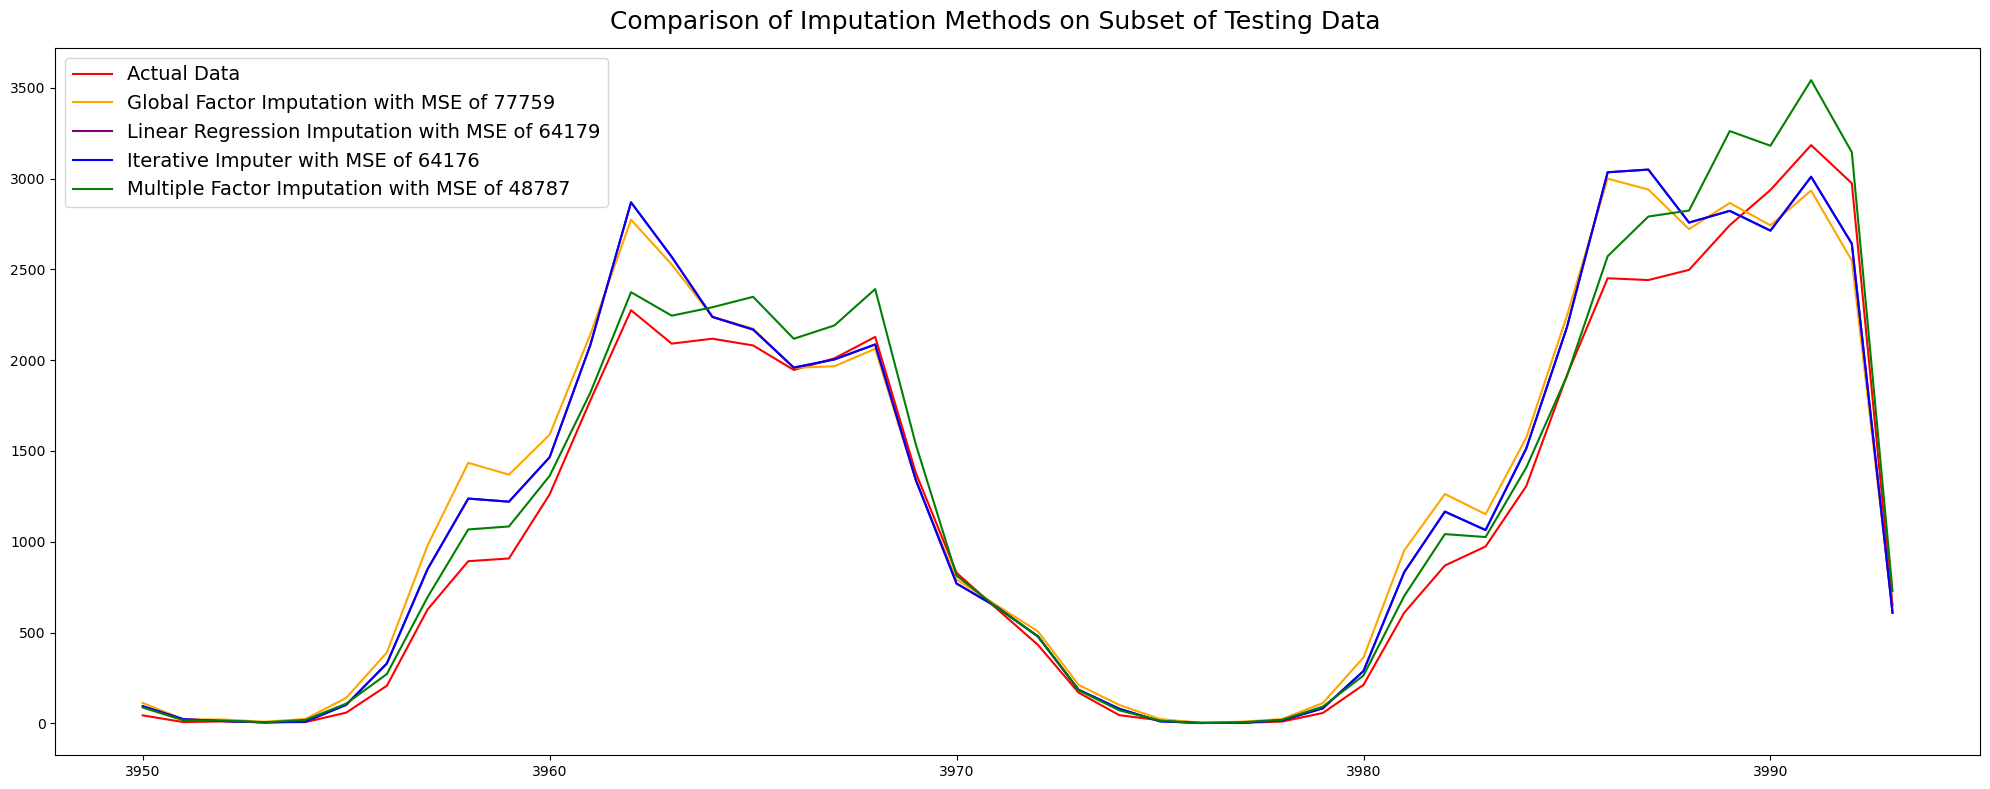

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df_test.bhfs_north[3950:], color="r", label="Actual Data")
ax.plot(df_test.y_hat_f1[3950:], color="orange", label=f"Global Factor Imputation with MSE of {mse_f1_imputation.astype(int).round(0)}")
ax.plot(df_test_m.y_hat_lr[3950:], color="purple", label=f"Linear Regression Imputation with MSE of {mse_lr_imputation.astype(int).round(0)}")
ax.plot(df_original.y_hat_ii[3950:], color="b", label=f"Iterative Imputer with MSE of {mse_iterative_imputation.astype(int).round(0)}")
ax.plot(df_test.y_hat_f2[3950:], color="green", label=f"Multiple Factor Imputation with MSE of {mse_f2_imputation.astype(int).round(0)}")
ax.legend(fontsize=14)
fig.suptitle("Comparison of Imputation Methods on Subset of Testing Data", fontsize=18)
plt.tight_layout()

## Random Stuff

In [ ]:
# SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(y_train, exog=X_train, order=(1, 2, 1), enforce_stationarity=False)
sarimax_fit = sarimax_model.fit()

y_pred1 = sarimax_fit.get_forecast(steps=len(X_test1), exog=X_test1)
mean1 = y_pred1.predicted_mean
mse_sarimax1 = mse(y_test1, mean1)

y_pred2 = sarimax_fit.get_forecast(steps=len(X_test2), exog=X_test2)
mean2 = y_pred2.predicted_mean
mse_sarimax1 = mse(y_test2, mean2)

In [ ]:
# VAR
from statsmodels.tsa.api import VAR

var_model = VAR(train)
var_fit = var_model.fit()
lag_order = var_fit.k_ar

y_pred1 = var_fit.forecast(test1.values, steps=len(test1))
mse_var1 = mse(y_test1, y_pred1[:, 2])

y_pred2 = var_fit.forecast(test2.values, steps=len(test2))
mse_var2 = mse(y_test2, y_pred2[:, 2])